In [3]:
import os
import cv2
import mediapipe as mp
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18
from tqdm import tqdm

# Configuración
image_size = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("CUDA available:", torch.cuda.is_available())
print("Using device:", device)

if torch.cuda.is_available():
    print("Nombre de la tarjeta gráfica:", torch.cuda.get_device_name(0))
    print("Memoria total de la tarjeta gráfica: {:.2f} GB".format(torch.cuda.get_device_properties(0).total_memory / 1e9))
    print("Memoria disponible antes del entrenamiento: {:.2f} GB".format(torch.cuda.memory_reserved(0) / 1e9))
    print("Memoria asignada antes del entrenamiento: {:.2f} GB".format(torch.cuda.memory_allocated(0) / 1e9))


CUDA available: True
Using device: cuda
Nombre de la tarjeta gráfica: NVIDIA GeForce RTX 3070
Memoria total de la tarjeta gráfica: 8.59 GB
Memoria disponible antes del entrenamiento: 0.00 GB
Memoria asignada antes del entrenamiento: 0.00 GB


In [4]:
import os
import cv2
import mediapipe as mp
import numpy as np
from tqdm import tqdm

mp_hands = mp.solutions.hands

def detect_and_crop_hand(image, margin=20):  # Añadir margen adicional
    with mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5) as hands:
        results = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                h, w, c = image.shape
                x_min = min([landmark.x for landmark in hand_landmarks.landmark]) * w
                x_max = max([landmark.x for landmark in hand_landmarks.landmark]) * w
                y_min = min([landmark.y for landmark in hand_landmarks.landmark]) * h
                y_max = max([landmark.y for landmark in hand_landmarks.landmark]) * h
                
                # Añadir margen
                x_min = max(0, int(x_min - margin))
                x_max = min(w, int(x_max + margin))
                y_min = max(0, int(y_min - margin))
                y_max = min(h, int(y_max + margin))
                
                cropped_image = image[y_min:y_max, x_min:x_max]
                return cropped_image
        return image

def preprocess_and_save_images(input_dir, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Crear un diccionario para contar las imágenes procesadas por letra
    image_counts = {}
    
    for root, _, files in os.walk(input_dir):
        # Obtener la letra/clase a partir de la ruta del directorio
        class_name = os.path.basename(root)
        if not files:
            continue
        
        # Inicializar el contador de imágenes para la clase si no existe
        if class_name not in image_counts:
            image_counts[class_name] = 0
        
        for file in tqdm(files, desc=f"Processing {class_name}"):
            if file.endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(root, file)
                image = cv2.imread(img_path)
                cropped_image = detect_and_crop_hand(image)
                
                if cropped_image is not None:
                    # Incrementar el contador de imágenes
                    image_counts[class_name] += 1
                    new_filename = f"{class_name}_{image_counts[class_name]}.jpg"
                    
                    # Crear el directorio de la clase en el directorio de salida si no existe
                    class_output_dir = os.path.join(output_dir, class_name)
                    if not os.path.exists(class_output_dir):
                        os.makedirs(class_output_dir)
                    
                    save_path = os.path.join(class_output_dir, new_filename)
                    cv2.imwrite(save_path, cropped_image)

# Preprocesar y guardar imágenes
preprocess_and_save_images('datasets/ASL_Alphabet_Dataset/asl_alphabet_train', 'datasets/ASL_Alphabet_Dataset/processed_train')


Processing Z: 100%|██████████| 7410/7410 [12:27<00:00,  9.91it/s]


In [12]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18

# Definir transformaciones avanzadas
image_size = 100
basic_transform = [
    transforms.Resize((image_size, image_size)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
]

augmentation_transform = [
    transforms.RandomRotation(15),
    transforms.RandomAffine(0, translate=(0.1, 0.1)),
    transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2)
]

transform = transforms.Compose(basic_transform + augmentation_transform)

# Cargar el conjunto de datos procesado
dataset = datasets.ImageFolder(root='datasets/ASL_Alphabet_Dataset/processed_train', transform=transform)

# Dividir el conjunto de datos en 95% entrenamiento y 5% prueba
train_size = int(0.95 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=8)


Primera imagen de cada clase preprocesada para entrenamiento:


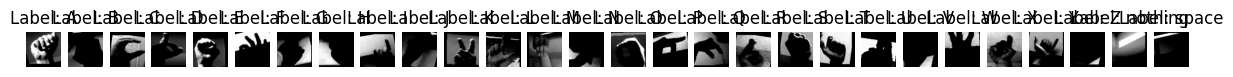

In [15]:
# Visualizar la primera imagen de cada clase antes de entrenar el modelo
def show_first_image_of_each_class(dataset, num_images=5):
    class_to_idx = dataset.dataset.class_to_idx
    idx_to_class = {v: k for k, v in class_to_idx.items()}
    first_images = []
    labels = []
    
    for class_name in class_to_idx.keys():
        class_index = class_to_idx[class_name]
        for idx in dataset.indices:
            img_path, target = dataset.dataset.samples[idx]
            if target == class_index:
                first_images.append(img_path)
                labels.append(class_name)
                break
    
    fig, axes = plt.subplots(1, len(first_images), figsize=(15, 15))
    for i, img_path in enumerate(first_images):
        img = Image.open(img_path).convert('L')
        img = transform(img)
        img = img.numpy()
        axes[i].imshow(img[0] * 0.5 + 0.5, cmap='gray')  # Des-normalizar y mostrar en escala de grises
        axes[i].set_title(f"Label: {labels[i]}")
        axes[i].axis('off')
    plt.show()

print("Primera imagen de cada clase preprocesada para entrenamiento:")
show_first_image_of_each_class(train_dataset)


Epoch 1/50: 100%|██████████| 3210/3210 [03:55<00:00, 13.63batch/s, loss=0.383, accuracy=78.2]


Epoch [1/50], Loss: 0.7035, Accuracy: 78.22%
Memoria asignada durante el entrenamiento: 0.63 GB
Memoria reservada durante el entrenamiento: 1.05 GB
Validation Loss: 0.4445, Validation Accuracy: 85.70%
Classification Report:
              precision    recall  f1-score   support

           A       0.78      0.89      0.83       403
           B       0.92      0.83      0.87       390
           C       0.94      0.87      0.90       407
           D       0.85      0.89      0.87       347
           E       0.92      0.73      0.82       428
           F       0.95      0.94      0.95       416
           G       0.93      0.72      0.81       408
           H       0.77      0.84      0.81       410
           I       0.84      0.84      0.84       388
           J       0.70      0.93      0.80       355
           K       0.86      0.79      0.82       391
           L       0.97      0.92      0.94       394
           M       0.63      0.88      0.73       379
           N       

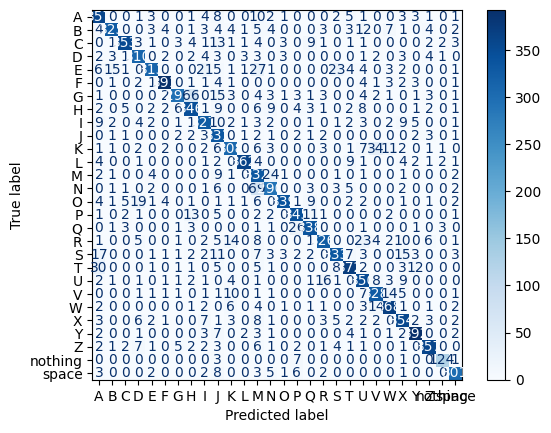

Epoch 2/50: 100%|██████████| 3210/3210 [03:56<00:00, 13.58batch/s, loss=0.429, accuracy=89]   


Epoch [2/50], Loss: 0.3525, Accuracy: 88.98%
Memoria asignada durante el entrenamiento: 0.63 GB
Memoria reservada durante el entrenamiento: 1.09 GB
Validation Loss: 0.3006, Validation Accuracy: 90.47%
Classification Report:
              precision    recall  f1-score   support

           A       0.89      0.90      0.90       403
           B       0.97      0.86      0.91       390
           C       0.99      0.90      0.94       407
           D       0.95      0.91      0.93       347
           E       0.87      0.93      0.90       428
           F       0.99      0.90      0.94       416
           G       0.95      0.89      0.92       408
           H       0.93      0.90      0.91       410
           I       0.91      0.88      0.90       388
           J       0.79      0.92      0.85       355
           K       0.95      0.81      0.87       391
           L       0.98      0.94      0.96       394
           M       0.84      0.91      0.87       379
           N       

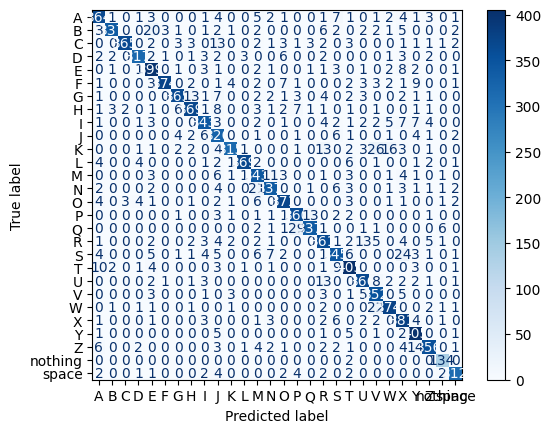

Epoch 3/50: 100%|██████████| 3210/3210 [03:51<00:00, 13.84batch/s, loss=0.295, accuracy=91.4] 


Epoch [3/50], Loss: 0.2731, Accuracy: 91.41%
Memoria asignada durante el entrenamiento: 0.63 GB
Memoria reservada durante el entrenamiento: 1.09 GB
Validation Loss: 0.2426, Validation Accuracy: 92.29%
Classification Report:
              precision    recall  f1-score   support

           A       0.90      0.91      0.90       403
           B       0.97      0.91      0.94       390
           C       0.98      0.91      0.94       407
           D       0.96      0.95      0.96       347
           E       0.95      0.92      0.93       428
           F       0.96      0.95      0.96       416
           G       0.91      0.94      0.92       408
           H       0.92      0.92      0.92       410
           I       0.92      0.90      0.91       388
           J       0.76      0.95      0.84       355
           K       0.92      0.91      0.91       391
           L       0.95      0.97      0.96       394
           M       0.84      0.94      0.89       379
           N       

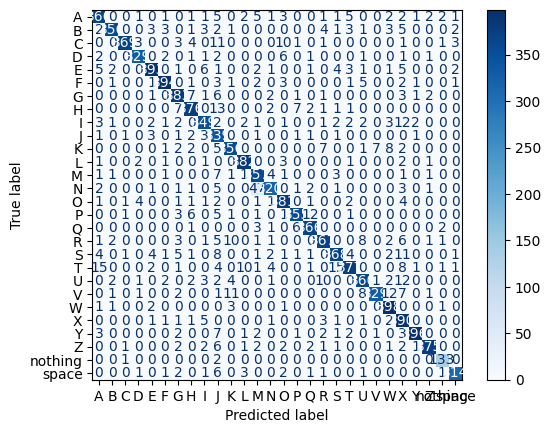

Epoch 4/50: 100%|██████████| 3210/3210 [03:50<00:00, 13.93batch/s, loss=0.338, accuracy=92.7] 


Epoch [4/50], Loss: 0.2306, Accuracy: 92.74%
Memoria asignada durante el entrenamiento: 0.63 GB
Memoria reservada durante el entrenamiento: 1.09 GB
Validation Loss: 0.2187, Validation Accuracy: 93.16%
Classification Report:
              precision    recall  f1-score   support

           A       0.90      0.92      0.91       403
           B       0.94      0.94      0.94       390
           C       0.96      0.88      0.92       407
           D       0.94      0.94      0.94       347
           E       0.94      0.93      0.93       428
           F       0.95      0.97      0.96       416
           G       0.96      0.92      0.94       408
           H       0.91      0.94      0.93       410
           I       0.90      0.93      0.91       388
           J       0.80      0.95      0.87       355
           K       0.98      0.89      0.93       391
           L       0.99      0.96      0.97       394
           M       0.88      0.93      0.90       379
           N       

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000002116F0CC550>
Traceback (most recent call last):
  File "c:\Users\207814636\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\utils\data\dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "c:\Users\207814636\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\utils\data\dataloader.py", line 1437, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


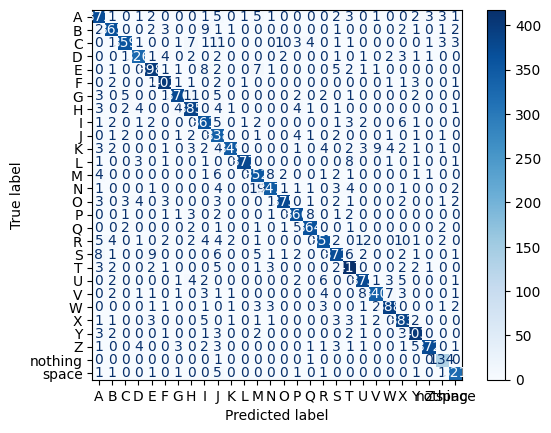

Epoch 5/50: 100%|██████████| 3210/3210 [03:50<00:00, 13.91batch/s, loss=0.142, accuracy=93.6] 


Epoch [5/50], Loss: 0.2037, Accuracy: 93.63%
Memoria asignada durante el entrenamiento: 0.39 GB
Memoria reservada durante el entrenamiento: 0.90 GB
Validation Loss: 0.1824, Validation Accuracy: 94.22%
Classification Report:
              precision    recall  f1-score   support

           A       0.92      0.92      0.92       403
           B       0.94      0.94      0.94       390
           C       0.96      0.94      0.95       407
           D       0.95      0.97      0.96       347
           E       0.97      0.92      0.94       428
           F       0.98      0.97      0.97       416
           G       0.95      0.93      0.94       408
           H       0.96      0.94      0.95       410
           I       0.93      0.94      0.93       388
           J       0.79      0.97      0.87       355
           K       0.94      0.92      0.93       391
           L       0.99      0.97      0.98       394
           M       0.94      0.90      0.92       379
           N       

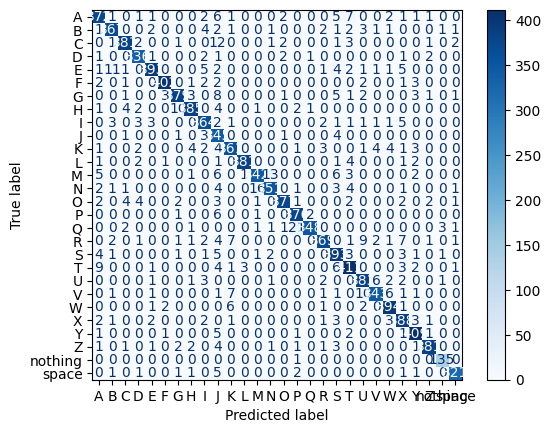

Epoch 6/50: 100%|██████████| 3210/3210 [03:48<00:00, 14.06batch/s, loss=0.0546, accuracy=96.1] 


Epoch [6/50], Loss: 0.1258, Accuracy: 96.06%
Memoria asignada durante el entrenamiento: 0.39 GB
Memoria reservada durante el entrenamiento: 0.90 GB
Validation Loss: 0.1156, Validation Accuracy: 96.40%
Classification Report:
              precision    recall  f1-score   support

           A       0.97      0.95      0.96       403
           B       0.98      0.95      0.97       390
           C       0.97      0.95      0.96       407
           D       0.99      0.97      0.98       347
           E       0.98      0.96      0.97       428
           F       0.97      0.98      0.97       416
           G       0.99      0.97      0.98       408
           H       0.98      0.96      0.97       410
           I       0.97      0.96      0.96       388
           J       0.81      0.98      0.89       355
           K       0.96      0.93      0.95       391
           L       0.99      0.99      0.99       394
           M       0.97      0.95      0.96       379
           N       

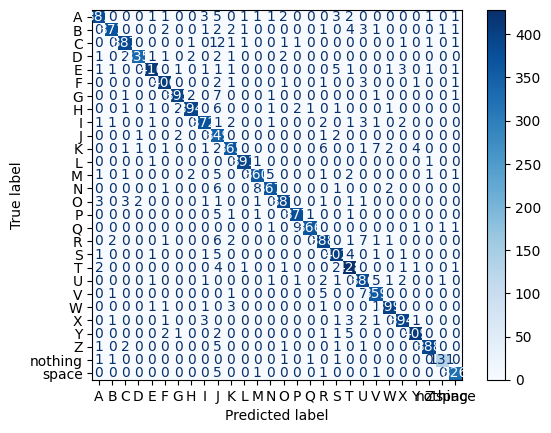

Epoch 7/50: 100%|██████████| 3210/3210 [03:49<00:00, 13.97batch/s, loss=0.134, accuracy=96.7]  


Epoch [7/50], Loss: 0.1050, Accuracy: 96.71%
Memoria asignada durante el entrenamiento: 0.39 GB
Memoria reservada durante el entrenamiento: 0.90 GB
Validation Loss: 0.0959, Validation Accuracy: 97.07%
Classification Report:
              precision    recall  f1-score   support

           A       0.98      0.95      0.96       403
           B       0.99      0.96      0.97       390
           C       0.98      0.96      0.97       407
           D       0.98      0.99      0.98       347
           E       0.96      0.96      0.96       428
           F       0.98      0.99      0.99       416
           G       0.97      0.96      0.96       408
           H       0.98      0.97      0.98       410
           I       0.97      0.97      0.97       388
           J       0.81      0.99      0.89       355
           K       0.97      0.96      0.96       391
           L       0.99      0.99      0.99       394
           M       0.95      0.97      0.96       379
           N       

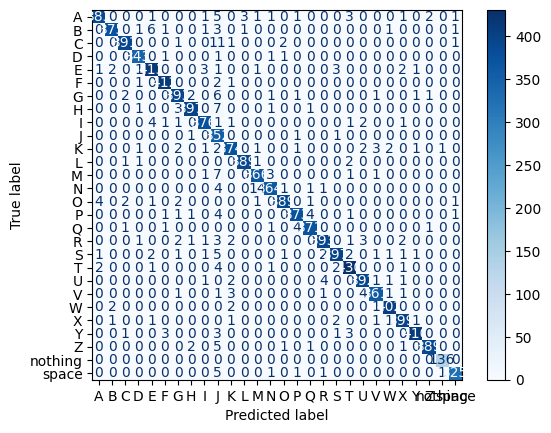

Epoch 8/50: 100%|██████████| 3210/3210 [03:49<00:00, 14.00batch/s, loss=0.0393, accuracy=97]   


Epoch [8/50], Loss: 0.0968, Accuracy: 96.98%
Memoria asignada durante el entrenamiento: 0.39 GB
Memoria reservada durante el entrenamiento: 0.90 GB
Validation Loss: 0.0981, Validation Accuracy: 96.96%
Classification Report:
              precision    recall  f1-score   support

           A       0.97      0.95      0.96       403
           B       0.98      0.95      0.97       390
           C       0.99      0.96      0.97       407
           D       0.99      0.98      0.98       347
           E       0.97      0.97      0.97       428
           F       0.98      0.98      0.98       416
           G       0.97      0.97      0.97       408
           H       0.97      0.98      0.97       410
           I       0.96      0.96      0.96       388
           J       0.81      0.99      0.89       355
           K       0.96      0.95      0.96       391
           L       0.99      1.00      0.99       394
           M       0.95      0.97      0.96       379
           N       

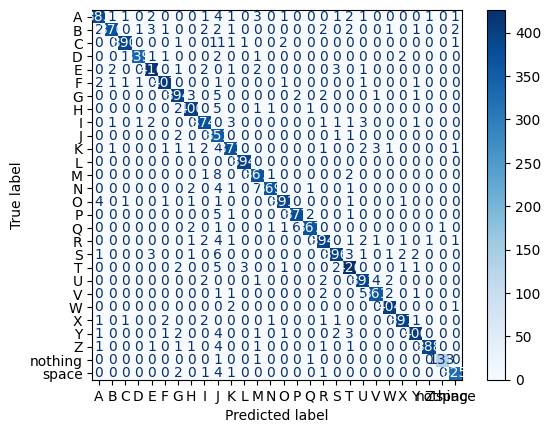

Epoch 9/50: 100%|██████████| 3210/3210 [03:52<00:00, 13.80batch/s, loss=0.0256, accuracy=97.1]  


Epoch [9/50], Loss: 0.0924, Accuracy: 97.07%
Memoria asignada durante el entrenamiento: 0.39 GB
Memoria reservada durante el entrenamiento: 0.90 GB
Validation Loss: 0.0960, Validation Accuracy: 96.95%
Classification Report:
              precision    recall  f1-score   support

           A       0.97      0.96      0.96       403
           B       0.96      0.95      0.96       390
           C       0.98      0.96      0.97       407
           D       0.99      0.97      0.98       347
           E       0.99      0.95      0.97       428
           F       1.00      0.99      0.99       416
           G       0.97      0.97      0.97       408
           H       0.98      0.96      0.97       410
           I       0.96      0.98      0.97       388
           J       0.80      0.98      0.88       355
           K       0.98      0.95      0.97       391
           L       1.00      0.99      0.99       394
           M       0.95      0.97      0.96       379
           N       

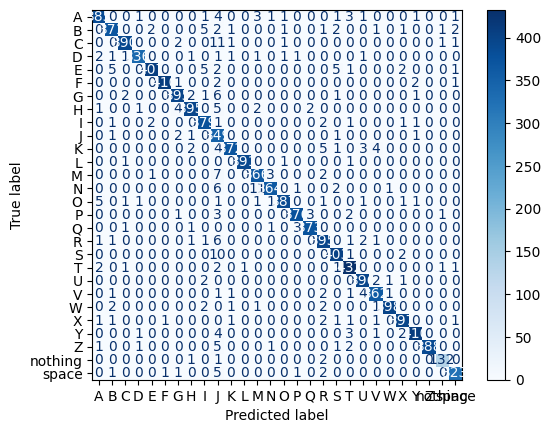

Epoch 10/50: 100%|██████████| 3210/3210 [03:53<00:00, 13.73batch/s, loss=0.000308, accuracy=97.2]


Epoch [10/50], Loss: 0.0879, Accuracy: 97.21%
Memoria asignada durante el entrenamiento: 0.39 GB
Memoria reservada durante el entrenamiento: 0.90 GB
Validation Loss: 0.0945, Validation Accuracy: 97.06%
Classification Report:
              precision    recall  f1-score   support

           A       0.97      0.96      0.97       403
           B       0.98      0.96      0.97       390
           C       0.98      0.96      0.97       407
           D       0.99      0.98      0.98       347
           E       0.95      0.97      0.96       428
           F       0.99      0.98      0.98       416
           G       0.98      0.97      0.97       408
           H       0.98      0.97      0.98       410
           I       0.97      0.96      0.96       388
           J       0.79      0.99      0.88       355
           K       0.98      0.96      0.97       391
           L       0.99      0.98      0.99       394
           M       0.95      0.97      0.96       379
           N      

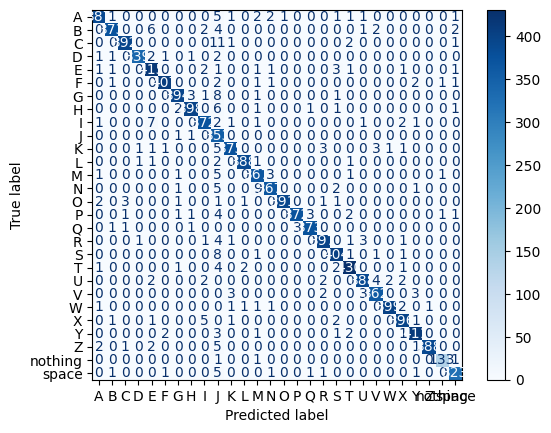

Epoch 11/50: 100%|██████████| 3210/3210 [03:52<00:00, 13.78batch/s, loss=0.205, accuracy=97.4]   


Epoch [11/50], Loss: 0.0824, Accuracy: 97.40%
Memoria asignada durante el entrenamiento: 0.39 GB
Memoria reservada durante el entrenamiento: 0.90 GB
Validation Loss: 0.0912, Validation Accuracy: 96.99%
Classification Report:
              precision    recall  f1-score   support

           A       0.97      0.96      0.96       403
           B       0.96      0.96      0.96       390
           C       0.98      0.96      0.97       407
           D       0.99      0.97      0.98       347
           E       0.97      0.96      0.97       428
           F       0.99      0.99      0.99       416
           G       0.98      0.97      0.97       408
           H       0.98      0.97      0.97       410
           I       0.94      0.97      0.96       388
           J       0.80      0.99      0.89       355
           K       0.97      0.96      0.97       391
           L       0.99      0.99      0.99       394
           M       0.96      0.97      0.96       379
           N      

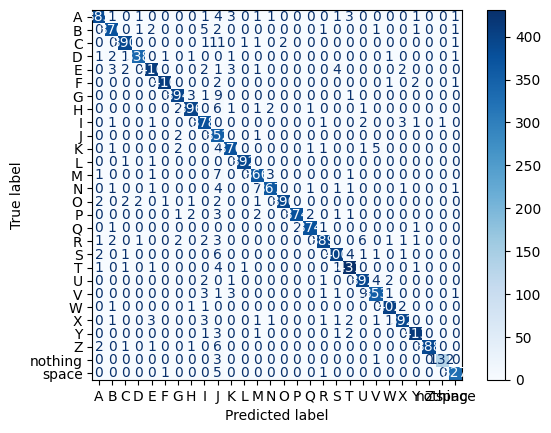

Epoch 12/50: 100%|██████████| 3210/3210 [03:49<00:00, 13.97batch/s, loss=0.0732, accuracy=97.5]  

Epoch [12/50], Loss: 0.0803, Accuracy: 97.49%
Memoria asignada durante el entrenamiento: 0.39 GB
Memoria reservada durante el entrenamiento: 0.90 GB


Validation Loss: 0.0857, Validation Accuracy: 97.28%
Classification Report:
              precision    recall  f1-score   support

           A       0.99      0.96      0.97       403
           B       0.97      0.96      0.97       390
           C       0.99      0.96      0.97       407
           D       0.99      0.98      0.99       347
           E       0.97      0.97      0.97       428
           F       0.99      0.99      0.99       416
           G       0.97      0.96      0.97       408
           H       0.99      0.97      0.98       410
           I       0.99      0.97      0.98       388
           J       0.81      0.99      0.89       355
           K       0.97      0.96      0.97       391
           L       0.99      0.99      0.99       394
           M       0.96      0.96      0.96       379
           N       0.98      0.96      0.97       385
           O       0.99      0.98      0.99       401
           P       0.98      0.97      0.98       386
     

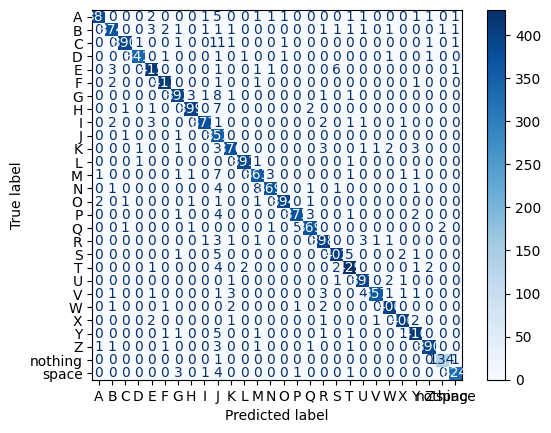

Epoch 13/50: 100%|██████████| 3210/3210 [04:04<00:00, 13.15batch/s, loss=0.132, accuracy=97.5]   


Epoch [13/50], Loss: 0.0786, Accuracy: 97.52%
Memoria asignada durante el entrenamiento: 0.39 GB
Memoria reservada durante el entrenamiento: 0.90 GB
Validation Loss: 0.0837, Validation Accuracy: 97.36%
Classification Report:
              precision    recall  f1-score   support

           A       0.98      0.97      0.97       403
           B       0.98      0.95      0.97       390
           C       0.98      0.96      0.97       407
           D       0.99      0.97      0.98       347
           E       0.98      0.97      0.97       428
           F       0.99      0.98      0.99       416
           G       0.97      0.98      0.97       408
           H       0.98      0.98      0.98       410
           I       0.97      0.97      0.97       388
           J       0.82      0.99      0.90       355
           K       0.97      0.97      0.97       391
           L       0.99      0.99      0.99       394
           M       0.97      0.97      0.97       379
           N      

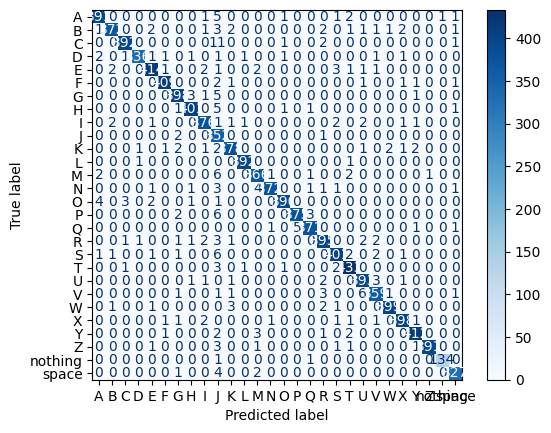

Epoch 14/50: 100%|██████████| 3210/3210 [03:59<00:00, 13.43batch/s, loss=0.129, accuracy=97.6]   


Epoch [14/50], Loss: 0.0777, Accuracy: 97.55%
Memoria asignada durante el entrenamiento: 0.39 GB
Memoria reservada durante el entrenamiento: 0.90 GB
Validation Loss: 0.0813, Validation Accuracy: 97.42%
Classification Report:
              precision    recall  f1-score   support

           A       0.98      0.96      0.97       403
           B       0.98      0.96      0.97       390
           C       0.99      0.96      0.97       407
           D       1.00      0.99      0.99       347
           E       0.99      0.96      0.97       428
           F       1.00      0.99      0.99       416
           G       0.98      0.98      0.98       408
           H       0.99      0.97      0.98       410
           I       0.97      0.97      0.97       388
           J       0.82      1.00      0.90       355
           K       0.98      0.96      0.97       391
           L       0.99      0.99      0.99       394
           M       0.95      0.97      0.96       379
           N      

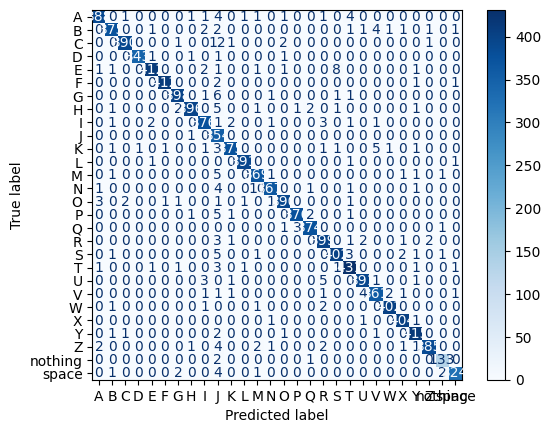

Epoch 15/50: 100%|██████████| 3210/3210 [04:00<00:00, 13.33batch/s, loss=0.0721, accuracy=97.5]  


Epoch [15/50], Loss: 0.0780, Accuracy: 97.54%
Memoria asignada durante el entrenamiento: 0.39 GB
Memoria reservada durante el entrenamiento: 0.90 GB
Validation Loss: 0.0846, Validation Accuracy: 97.37%
Classification Report:
              precision    recall  f1-score   support

           A       0.99      0.96      0.97       403
           B       0.98      0.96      0.97       390
           C       0.99      0.96      0.98       407
           D       0.99      0.97      0.98       347
           E       0.98      0.97      0.97       428
           F       0.99      0.99      0.99       416
           G       0.98      0.97      0.97       408
           H       0.97      0.97      0.97       410
           I       0.98      0.98      0.98       388
           J       0.81      0.99      0.89       355
           K       0.98      0.96      0.97       391
           L       0.99      0.99      0.99       394
           M       0.96      0.96      0.96       379
           N      

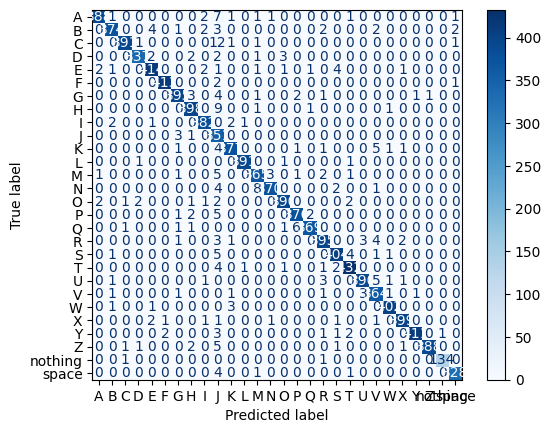

Epoch 16/50: 100%|██████████| 3210/3210 [03:55<00:00, 13.65batch/s, loss=0.154, accuracy=97.6]   


Epoch [16/50], Loss: 0.0777, Accuracy: 97.56%
Memoria asignada durante el entrenamiento: 0.39 GB
Memoria reservada durante el entrenamiento: 0.90 GB
Validation Loss: 0.0825, Validation Accuracy: 97.38%
Classification Report:
              precision    recall  f1-score   support

           A       0.99      0.97      0.98       403
           B       0.98      0.96      0.97       390
           C       0.99      0.96      0.98       407
           D       0.98      0.97      0.98       347
           E       0.98      0.97      0.97       428
           F       1.00      0.98      0.99       416
           G       0.98      0.97      0.98       408
           H       0.99      0.98      0.98       410
           I       0.97      0.96      0.97       388
           J       0.80      0.99      0.89       355
           K       0.96      0.95      0.96       391
           L       0.99      0.98      0.99       394
           M       0.97      0.96      0.97       379
           N      

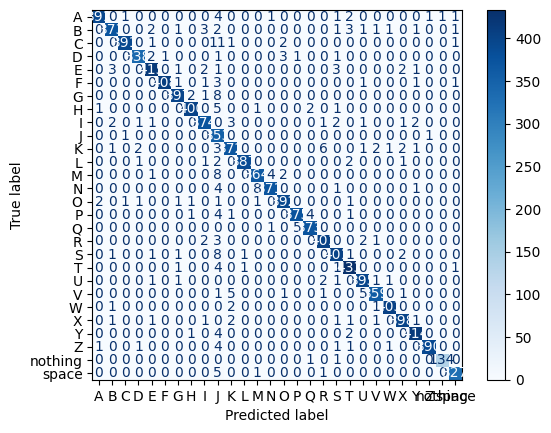

Epoch 17/50: 100%|██████████| 3210/3210 [03:50<00:00, 13.92batch/s, loss=0.206, accuracy=97.6]   


Epoch [17/50], Loss: 0.0764, Accuracy: 97.59%
Memoria asignada durante el entrenamiento: 0.39 GB
Memoria reservada durante el entrenamiento: 0.90 GB
Validation Loss: 0.0791, Validation Accuracy: 97.56%
Classification Report:
              precision    recall  f1-score   support

           A       0.97      0.96      0.97       403
           B       0.97      0.97      0.97       390
           C       0.98      0.96      0.97       407
           D       0.99      0.99      0.99       347
           E       0.97      0.97      0.97       428
           F       1.00      0.99      0.99       416
           G       0.99      0.97      0.98       408
           H       0.98      0.98      0.98       410
           I       0.98      0.98      0.98       388
           J       0.82      0.99      0.90       355
           K       0.97      0.96      0.97       391
           L       0.99      1.00      1.00       394
           M       0.97      0.97      0.97       379
           N      

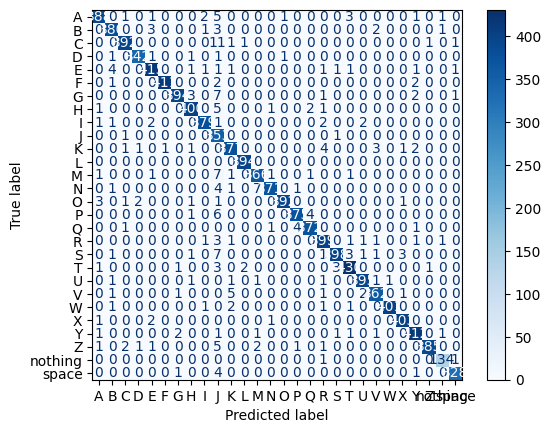

Epoch 18/50: 100%|██████████| 3210/3210 [03:50<00:00, 13.95batch/s, loss=0.00844, accuracy=97.6] 


Epoch [18/50], Loss: 0.0767, Accuracy: 97.59%
Memoria asignada durante el entrenamiento: 0.39 GB
Memoria reservada durante el entrenamiento: 0.90 GB
Validation Loss: 0.0799, Validation Accuracy: 97.51%
Classification Report:
              precision    recall  f1-score   support

           A       0.98      0.96      0.97       403
           B       0.98      0.97      0.97       390
           C       0.99      0.96      0.97       407
           D       0.99      0.98      0.99       347
           E       0.99      0.97      0.98       428
           F       0.99      0.98      0.99       416
           G       0.99      0.98      0.98       408
           H       0.99      0.97      0.98       410
           I       0.97      0.98      0.98       388
           J       0.80      0.99      0.88       355
           K       0.98      0.96      0.97       391
           L       1.00      0.99      0.99       394
           M       0.97      0.97      0.97       379
           N      

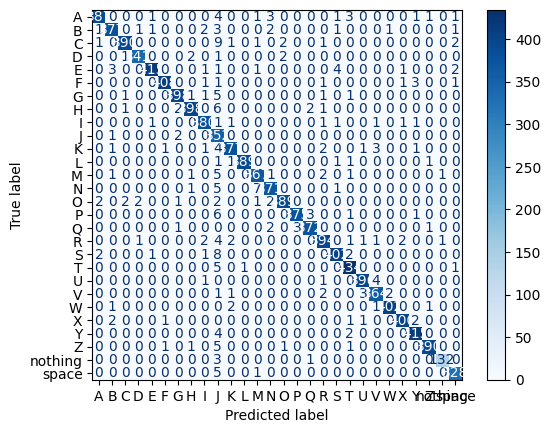

Epoch 19/50: 100%|██████████| 3210/3210 [03:44<00:00, 14.28batch/s, loss=0.0228, accuracy=97.6]  


Epoch [19/50], Loss: 0.0772, Accuracy: 97.57%
Memoria asignada durante el entrenamiento: 0.39 GB
Memoria reservada durante el entrenamiento: 0.90 GB
Validation Loss: 0.0826, Validation Accuracy: 97.44%
Classification Report:
              precision    recall  f1-score   support

           A       0.98      0.97      0.97       403
           B       0.98      0.97      0.97       390
           C       0.99      0.95      0.97       407
           D       0.99      0.97      0.98       347
           E       0.97      0.97      0.97       428
           F       0.99      0.98      0.99       416
           G       0.99      0.97      0.98       408
           H       0.98      0.98      0.98       410
           I       0.96      0.97      0.97       388
           J       0.80      0.99      0.89       355
           K       0.96      0.96      0.96       391
           L       1.00      0.99      0.99       394
           M       0.96      0.96      0.96       379
           N      

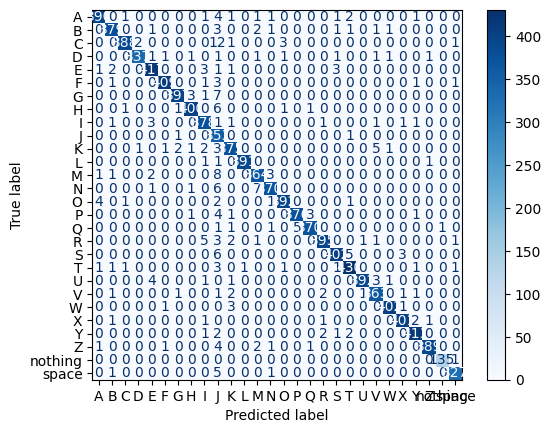

Epoch 20/50: 100%|██████████| 3210/3210 [03:41<00:00, 14.48batch/s, loss=0.116, accuracy=97.6]   


Epoch [20/50], Loss: 0.0758, Accuracy: 97.63%
Memoria asignada durante el entrenamiento: 0.39 GB
Memoria reservada durante el entrenamiento: 0.90 GB
Validation Loss: 0.0818, Validation Accuracy: 97.32%
Classification Report:
              precision    recall  f1-score   support

           A       0.97      0.96      0.97       403
           B       0.97      0.96      0.97       390
           C       0.98      0.96      0.97       407
           D       0.99      0.98      0.98       347
           E       0.98      0.96      0.97       428
           F       1.00      0.99      0.99       416
           G       0.99      0.97      0.98       408
           H       0.98      0.97      0.98       410
           I       0.99      0.97      0.98       388
           J       0.81      0.99      0.89       355
           K       0.97      0.96      0.97       391
           L       1.00      0.99      1.00       394
           M       0.98      0.96      0.97       379
           N      

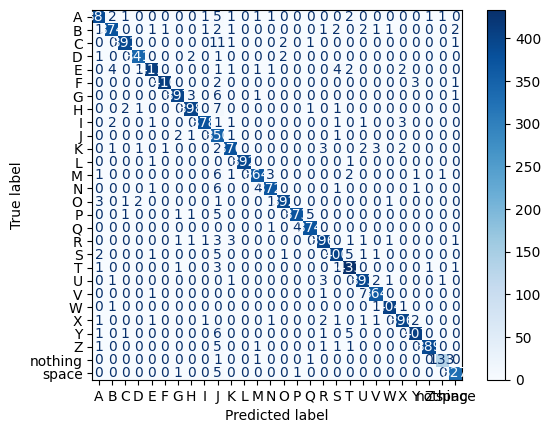

Epoch 21/50: 100%|██████████| 3210/3210 [03:43<00:00, 14.37batch/s, loss=0.0423, accuracy=97.6]  


Epoch [21/50], Loss: 0.0767, Accuracy: 97.58%
Memoria asignada durante el entrenamiento: 0.39 GB
Memoria reservada durante el entrenamiento: 0.90 GB
Validation Loss: 0.0836, Validation Accuracy: 97.40%
Classification Report:
              precision    recall  f1-score   support

           A       0.98      0.97      0.97       403
           B       0.98      0.97      0.97       390
           C       0.99      0.96      0.98       407
           D       0.99      0.99      0.99       347
           E       0.98      0.97      0.98       428
           F       1.00      0.99      0.99       416
           G       0.97      0.97      0.97       408
           H       0.99      0.97      0.98       410
           I       0.97      0.97      0.97       388
           J       0.79      0.99      0.88       355
           K       0.96      0.95      0.96       391
           L       1.00      0.99      0.99       394
           M       0.98      0.97      0.97       379
           N      

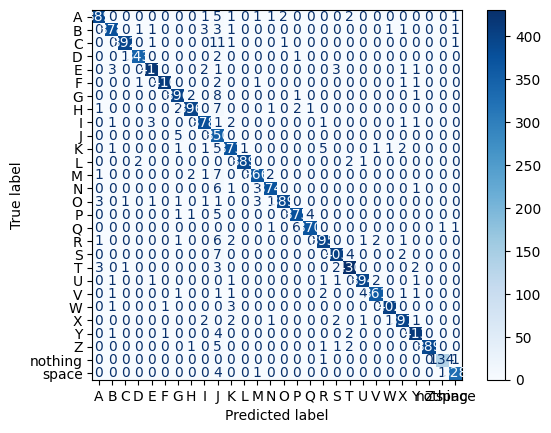

Epoch 22/50: 100%|██████████| 3210/3210 [03:44<00:00, 14.30batch/s, loss=0.0505, accuracy=97.6]  


Epoch [22/50], Loss: 0.0767, Accuracy: 97.59%
Memoria asignada durante el entrenamiento: 0.39 GB
Memoria reservada durante el entrenamiento: 0.90 GB
Validation Loss: 0.0788, Validation Accuracy: 97.49%
Classification Report:
              precision    recall  f1-score   support

           A       0.99      0.97      0.98       403
           B       0.98      0.95      0.97       390
           C       0.99      0.96      0.97       407
           D       0.99      0.98      0.98       347
           E       0.97      0.97      0.97       428
           F       1.00      0.99      0.99       416
           G       0.98      0.98      0.98       408
           H       1.00      0.97      0.98       410
           I       0.98      0.97      0.97       388
           J       0.80      0.99      0.89       355
           K       0.97      0.97      0.97       391
           L       0.99      0.99      0.99       394
           M       0.96      0.96      0.96       379
           N      

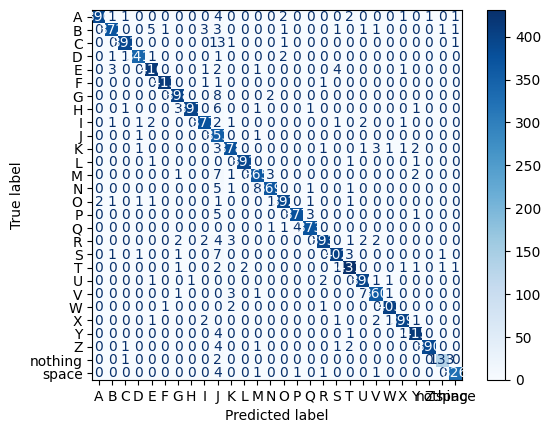

Epoch 23/50: 100%|██████████| 3210/3210 [03:45<00:00, 14.26batch/s, loss=0.0273, accuracy=97.6]  


Epoch [23/50], Loss: 0.0759, Accuracy: 97.62%
Memoria asignada durante el entrenamiento: 0.39 GB
Memoria reservada durante el entrenamiento: 0.90 GB
Validation Loss: 0.0788, Validation Accuracy: 97.53%
Classification Report:
              precision    recall  f1-score   support

           A       0.98      0.97      0.97       403
           B       0.97      0.97      0.97       390
           C       0.99      0.96      0.98       407
           D       0.99      0.98      0.99       347
           E       0.99      0.98      0.98       428
           F       1.00      0.99      0.99       416
           G       0.98      0.98      0.98       408
           H       0.98      0.97      0.98       410
           I       0.98      0.98      0.98       388
           J       0.82      1.00      0.90       355
           K       0.99      0.96      0.97       391
           L       0.99      0.99      0.99       394
           M       0.96      0.97      0.96       379
           N      

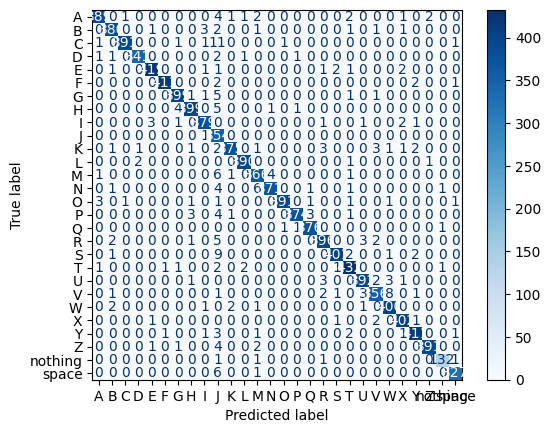

Epoch 24/50: 100%|██████████| 3210/3210 [03:44<00:00, 14.28batch/s, loss=0.0846, accuracy=97.6]  


Epoch [24/50], Loss: 0.0766, Accuracy: 97.59%
Memoria asignada durante el entrenamiento: 0.39 GB
Memoria reservada durante el entrenamiento: 0.90 GB
Validation Loss: 0.0824, Validation Accuracy: 97.47%
Classification Report:
              precision    recall  f1-score   support

           A       0.98      0.96      0.97       403
           B       0.98      0.97      0.98       390
           C       0.99      0.96      0.98       407
           D       0.99      0.98      0.98       347
           E       0.97      0.98      0.98       428
           F       1.00      0.99      0.99       416
           G       0.98      0.97      0.97       408
           H       0.98      0.97      0.98       410
           I       0.96      0.98      0.97       388
           J       0.81      0.99      0.89       355
           K       0.97      0.97      0.97       391
           L       0.99      1.00      1.00       394
           M       0.97      0.96      0.97       379
           N      

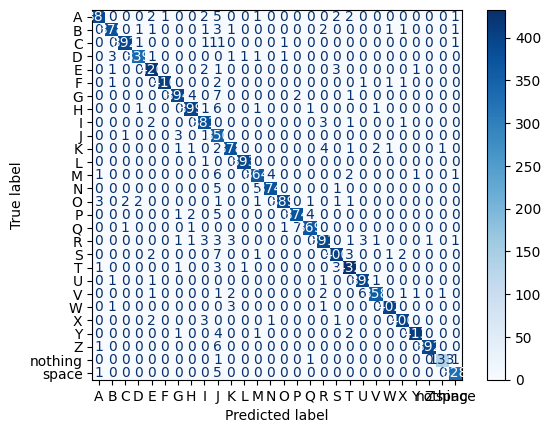

Epoch 25/50: 100%|██████████| 3210/3210 [03:44<00:00, 14.31batch/s, loss=0.138, accuracy=97.6]   


Epoch [25/50], Loss: 0.0772, Accuracy: 97.56%
Memoria asignada durante el entrenamiento: 0.39 GB
Memoria reservada durante el entrenamiento: 0.90 GB
Validation Loss: 0.0865, Validation Accuracy: 97.49%
Classification Report:
              precision    recall  f1-score   support

           A       0.98      0.96      0.97       403
           B       0.96      0.97      0.97       390
           C       0.99      0.97      0.98       407
           D       0.99      0.99      0.99       347
           E       0.97      0.97      0.97       428
           F       1.00      0.99      0.99       416
           G       0.98      0.97      0.98       408
           H       0.99      0.97      0.98       410
           I       0.97      0.97      0.97       388
           J       0.82      1.00      0.90       355
           K       0.98      0.96      0.97       391
           L       0.99      0.99      0.99       394
           M       0.96      0.95      0.95       379
           N      

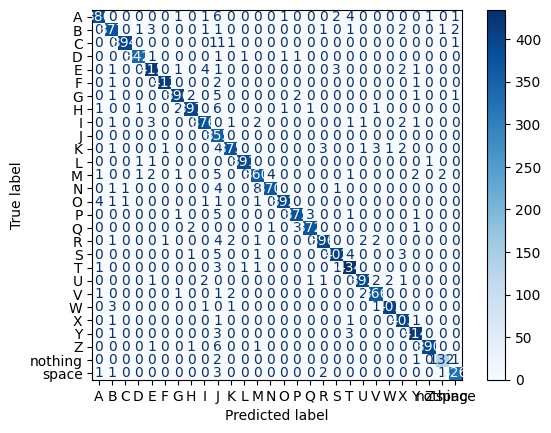

Epoch 26/50: 100%|██████████| 3210/3210 [03:43<00:00, 14.37batch/s, loss=0.00343, accuracy=97.6] 


Epoch [26/50], Loss: 0.0772, Accuracy: 97.55%
Memoria asignada durante el entrenamiento: 0.39 GB
Memoria reservada durante el entrenamiento: 0.90 GB
Validation Loss: 0.0853, Validation Accuracy: 97.23%
Classification Report:
              precision    recall  f1-score   support

           A       0.97      0.96      0.97       403
           B       0.98      0.96      0.97       390
           C       0.98      0.96      0.97       407
           D       0.98      0.98      0.98       347
           E       0.98      0.96      0.97       428
           F       0.99      0.98      0.98       416
           G       0.97      0.97      0.97       408
           H       0.98      0.97      0.98       410
           I       0.96      0.97      0.97       388
           J       0.81      0.98      0.89       355
           K       0.96      0.96      0.96       391
           L       0.99      0.99      0.99       394
           M       0.96      0.96      0.96       379
           N      

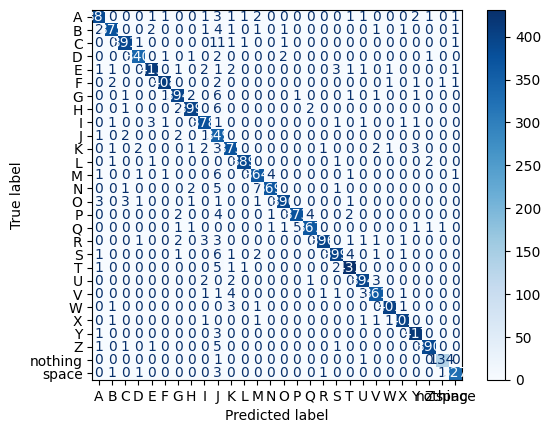

Epoch 27/50: 100%|██████████| 3210/3210 [03:43<00:00, 14.34batch/s, loss=0.0228, accuracy=97.6]  


Epoch [27/50], Loss: 0.0768, Accuracy: 97.59%
Memoria asignada durante el entrenamiento: 0.39 GB
Memoria reservada durante el entrenamiento: 0.90 GB
Validation Loss: 0.0848, Validation Accuracy: 97.37%
Classification Report:
              precision    recall  f1-score   support

           A       0.98      0.96      0.97       403
           B       0.97      0.95      0.96       390
           C       0.99      0.96      0.98       407
           D       0.99      0.98      0.99       347
           E       0.97      0.97      0.97       428
           F       1.00      0.99      0.99       416
           G       0.98      0.98      0.98       408
           H       0.98      0.97      0.97       410
           I       0.97      0.97      0.97       388
           J       0.82      0.99      0.89       355
           K       0.96      0.96      0.96       391
           L       0.99      0.99      0.99       394
           M       0.97      0.96      0.97       379
           N      

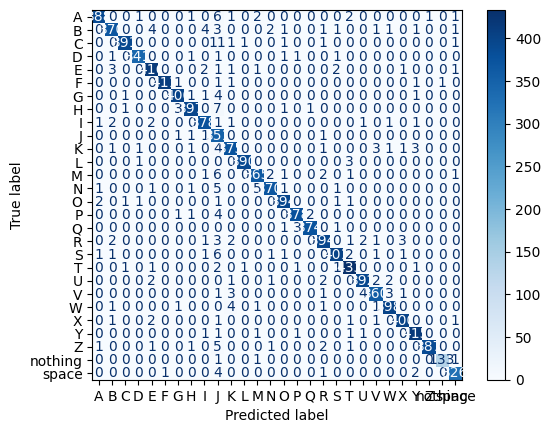

Epoch 28/50: 100%|██████████| 3210/3210 [03:44<00:00, 14.31batch/s, loss=0.0445, accuracy=97.5]  


Epoch [28/50], Loss: 0.0775, Accuracy: 97.55%
Memoria asignada durante el entrenamiento: 0.39 GB
Memoria reservada durante el entrenamiento: 0.90 GB
Validation Loss: 0.0788, Validation Accuracy: 97.41%
Classification Report:
              precision    recall  f1-score   support

           A       0.97      0.97      0.97       403
           B       0.99      0.97      0.98       390
           C       0.99      0.96      0.98       407
           D       0.99      0.99      0.99       347
           E       0.99      0.97      0.98       428
           F       0.99      0.98      0.99       416
           G       0.97      0.97      0.97       408
           H       0.98      0.96      0.97       410
           I       0.98      0.97      0.98       388
           J       0.82      0.99      0.90       355
           K       0.97      0.96      0.96       391
           L       0.99      0.99      0.99       394
           M       0.98      0.96      0.97       379
           N      

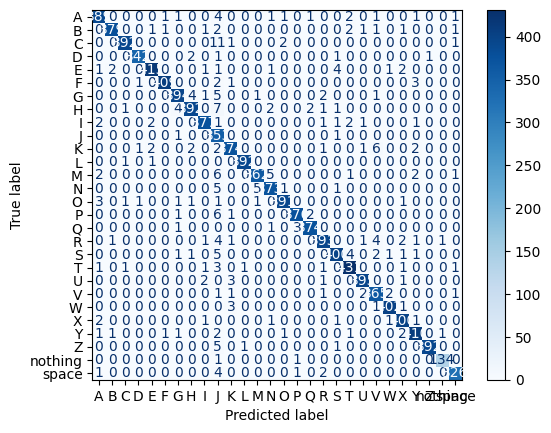

Epoch 29/50: 100%|██████████| 3210/3210 [03:43<00:00, 14.39batch/s, loss=0.0185, accuracy=97.6]  


Epoch [29/50], Loss: 0.0773, Accuracy: 97.59%
Memoria asignada durante el entrenamiento: 0.39 GB
Memoria reservada durante el entrenamiento: 0.90 GB
Validation Loss: 0.0856, Validation Accuracy: 97.32%
Classification Report:
              precision    recall  f1-score   support

           A       0.98      0.96      0.97       403
           B       0.97      0.96      0.96       390
           C       0.99      0.96      0.97       407
           D       0.98      0.97      0.98       347
           E       0.98      0.97      0.98       428
           F       0.99      0.99      0.99       416
           G       0.97      0.98      0.97       408
           H       0.97      0.96      0.96       410
           I       0.96      0.97      0.96       388
           J       0.82      0.99      0.89       355
           K       0.98      0.97      0.97       391
           L       0.99      0.99      0.99       394
           M       0.95      0.96      0.96       379
           N      

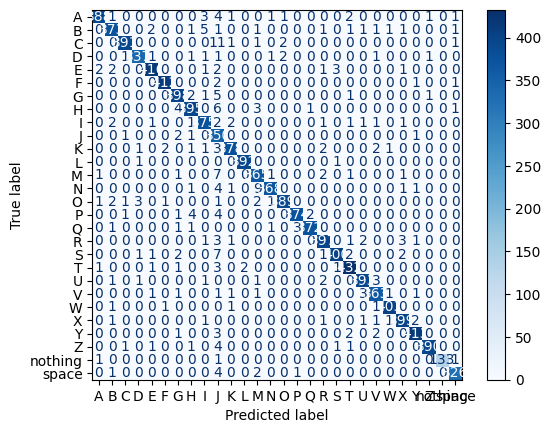

Epoch 30/50: 100%|██████████| 3210/3210 [03:44<00:00, 14.31batch/s, loss=0.0558, accuracy=97.6]  


Epoch [30/50], Loss: 0.0761, Accuracy: 97.60%
Memoria asignada durante el entrenamiento: 0.39 GB
Memoria reservada durante el entrenamiento: 0.90 GB
Validation Loss: 0.0774, Validation Accuracy: 97.50%
Classification Report:
              precision    recall  f1-score   support

           A       0.98      0.97      0.98       403
           B       0.97      0.97      0.97       390
           C       0.99      0.96      0.97       407
           D       0.99      0.99      0.99       347
           E       0.97      0.97      0.97       428
           F       1.00      0.99      0.99       416
           G       0.97      0.97      0.97       408
           H       0.99      0.97      0.98       410
           I       0.97      0.98      0.98       388
           J       0.81      1.00      0.89       355
           K       0.98      0.97      0.98       391
           L       0.99      0.99      0.99       394
           M       0.97      0.96      0.96       379
           N      

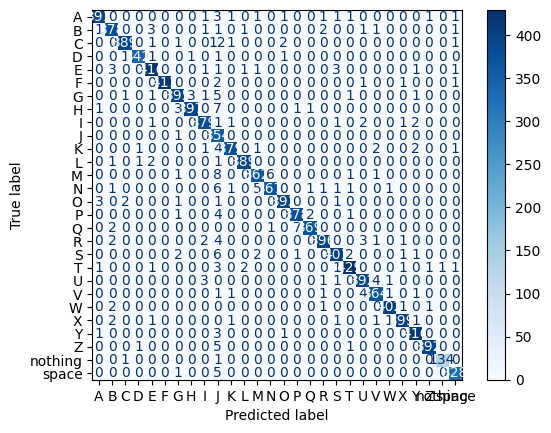

Epoch 31/50: 100%|██████████| 3210/3210 [03:44<00:00, 14.32batch/s, loss=0.0505, accuracy=97.6]  


Epoch [31/50], Loss: 0.0757, Accuracy: 97.58%
Memoria asignada durante el entrenamiento: 0.39 GB
Memoria reservada durante el entrenamiento: 0.90 GB
Validation Loss: 0.0809, Validation Accuracy: 97.54%
Classification Report:
              precision    recall  f1-score   support

           A       0.99      0.96      0.97       403
           B       0.98      0.97      0.97       390
           C       0.99      0.96      0.98       407
           D       0.99      0.97      0.98       347
           E       0.98      0.98      0.98       428
           F       0.99      0.99      0.99       416
           G       0.98      0.97      0.98       408
           H       0.98      0.97      0.97       410
           I       0.98      0.97      0.98       388
           J       0.82      1.00      0.90       355
           K       0.96      0.96      0.96       391
           L       1.00      1.00      1.00       394
           M       0.97      0.95      0.96       379
           N      

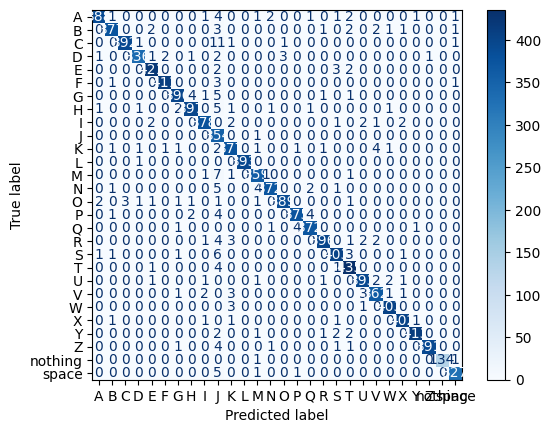

Epoch 32/50: 100%|██████████| 3210/3210 [03:44<00:00, 14.31batch/s, loss=0.0284, accuracy=97.6]  


Epoch [32/50], Loss: 0.0772, Accuracy: 97.56%
Memoria asignada durante el entrenamiento: 0.39 GB
Memoria reservada durante el entrenamiento: 0.90 GB
Validation Loss: 0.0834, Validation Accuracy: 97.49%
Classification Report:
              precision    recall  f1-score   support

           A       0.98      0.97      0.97       403
           B       0.98      0.97      0.97       390
           C       0.99      0.97      0.98       407
           D       0.99      0.98      0.99       347
           E       0.98      0.97      0.97       428
           F       0.99      0.99      0.99       416
           G       0.97      0.98      0.97       408
           H       0.98      0.96      0.97       410
           I       0.96      0.97      0.96       388
           J       0.80      0.99      0.89       355
           K       0.97      0.97      0.97       391
           L       0.99      0.99      0.99       394
           M       0.97      0.97      0.97       379
           N      

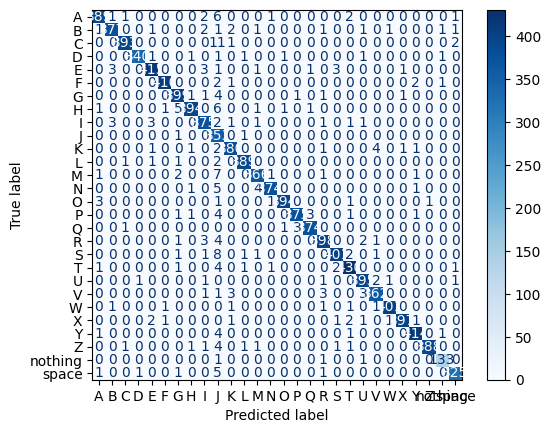

Epoch 33/50: 100%|██████████| 3210/3210 [03:45<00:00, 14.25batch/s, loss=0.152, accuracy=97.6]   


Epoch [33/50], Loss: 0.0774, Accuracy: 97.58%
Memoria asignada durante el entrenamiento: 0.39 GB
Memoria reservada durante el entrenamiento: 0.90 GB
Validation Loss: 0.0805, Validation Accuracy: 97.47%
Classification Report:
              precision    recall  f1-score   support

           A       0.98      0.95      0.97       403
           B       0.98      0.97      0.98       390
           C       0.98      0.96      0.97       407
           D       0.99      0.98      0.99       347
           E       0.97      0.97      0.97       428
           F       0.99      0.99      0.99       416
           G       0.97      0.97      0.97       408
           H       0.98      0.97      0.98       410
           I       0.98      0.98      0.98       388
           J       0.82      0.99      0.90       355
           K       0.98      0.97      0.97       391
           L       0.99      0.99      0.99       394
           M       0.96      0.95      0.96       379
           N      

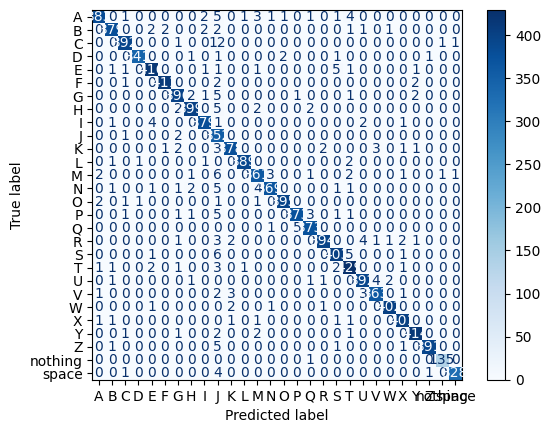

Epoch 34/50: 100%|██████████| 3210/3210 [03:45<00:00, 14.25batch/s, loss=0.00625, accuracy=97.6] 


Epoch [34/50], Loss: 0.0765, Accuracy: 97.58%
Memoria asignada durante el entrenamiento: 0.39 GB
Memoria reservada durante el entrenamiento: 0.90 GB
Validation Loss: 0.0809, Validation Accuracy: 97.39%
Classification Report:
              precision    recall  f1-score   support

           A       0.98      0.96      0.97       403
           B       0.98      0.97      0.97       390
           C       0.99      0.95      0.97       407
           D       0.99      0.98      0.98       347
           E       0.98      0.97      0.98       428
           F       0.99      0.99      0.99       416
           G       0.99      0.97      0.98       408
           H       0.99      0.98      0.98       410
           I       0.97      0.98      0.97       388
           J       0.80      0.99      0.89       355
           K       0.97      0.95      0.96       391
           L       0.99      0.99      0.99       394
           M       0.97      0.96      0.96       379
           N      

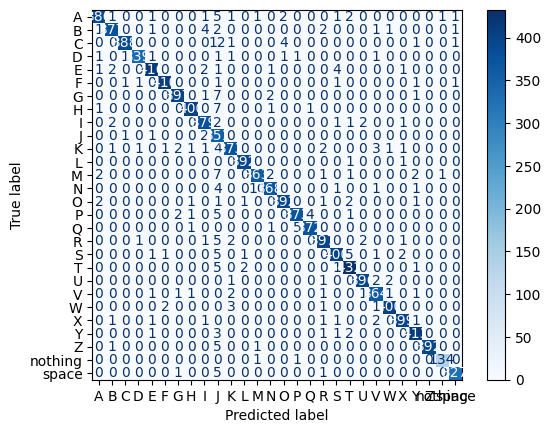

Epoch 35/50: 100%|██████████| 3210/3210 [03:48<00:00, 14.05batch/s, loss=0.0018, accuracy=97.6]  


Epoch [35/50], Loss: 0.0768, Accuracy: 97.58%
Memoria asignada durante el entrenamiento: 0.39 GB
Memoria reservada durante el entrenamiento: 0.90 GB
Validation Loss: 0.0780, Validation Accuracy: 97.47%
Classification Report:
              precision    recall  f1-score   support

           A       0.98      0.96      0.97       403
           B       0.98      0.96      0.97       390
           C       0.99      0.96      0.98       407
           D       0.99      0.98      0.99       347
           E       0.96      0.97      0.97       428
           F       0.99      0.98      0.99       416
           G       0.98      0.98      0.98       408
           H       0.99      0.98      0.98       410
           I       0.96      0.97      0.97       388
           J       0.81      1.00      0.89       355
           K       0.98      0.97      0.97       391
           L       1.00      0.99      0.99       394
           M       0.98      0.96      0.97       379
           N      

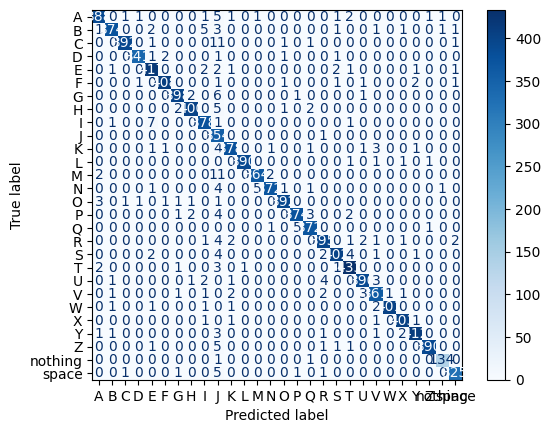

Epoch 36/50: 100%|██████████| 3210/3210 [03:51<00:00, 13.85batch/s, loss=0.0361, accuracy=97.6]  


Epoch [36/50], Loss: 0.0769, Accuracy: 97.58%
Memoria asignada durante el entrenamiento: 0.39 GB
Memoria reservada durante el entrenamiento: 0.90 GB
Validation Loss: 0.0784, Validation Accuracy: 97.45%
Classification Report:
              precision    recall  f1-score   support

           A       0.99      0.97      0.98       403
           B       0.97      0.96      0.97       390
           C       0.98      0.96      0.97       407
           D       0.99      0.98      0.98       347
           E       0.98      0.97      0.98       428
           F       0.99      0.99      0.99       416
           G       0.97      0.97      0.97       408
           H       0.98      0.97      0.98       410
           I       0.96      0.98      0.97       388
           J       0.82      0.99      0.90       355
           K       0.96      0.95      0.96       391
           L       0.99      0.99      0.99       394
           M       0.98      0.95      0.96       379
           N      

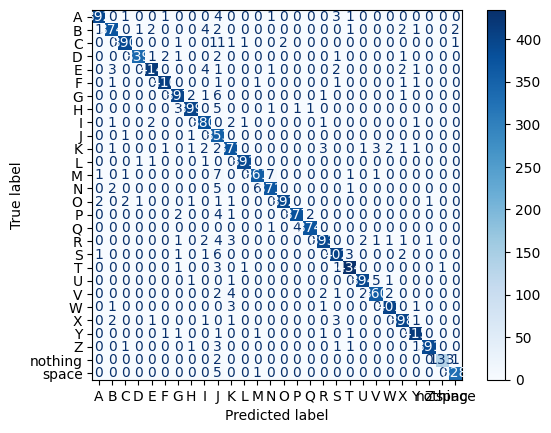

Epoch 37/50: 100%|██████████| 3210/3210 [03:48<00:00, 14.03batch/s, loss=0.122, accuracy=97.6]   


Epoch [37/50], Loss: 0.0771, Accuracy: 97.58%
Memoria asignada durante el entrenamiento: 0.39 GB
Memoria reservada durante el entrenamiento: 0.90 GB
Validation Loss: 0.0838, Validation Accuracy: 97.34%
Classification Report:
              precision    recall  f1-score   support

           A       0.98      0.97      0.97       403
           B       0.98      0.96      0.97       390
           C       0.99      0.96      0.98       407
           D       0.98      0.99      0.98       347
           E       0.99      0.96      0.97       428
           F       0.99      0.98      0.99       416
           G       0.97      0.97      0.97       408
           H       0.98      0.97      0.97       410
           I       0.97      0.97      0.97       388
           J       0.80      1.00      0.89       355
           K       0.98      0.96      0.97       391
           L       0.99      0.99      0.99       394
           M       0.95      0.96      0.96       379
           N      

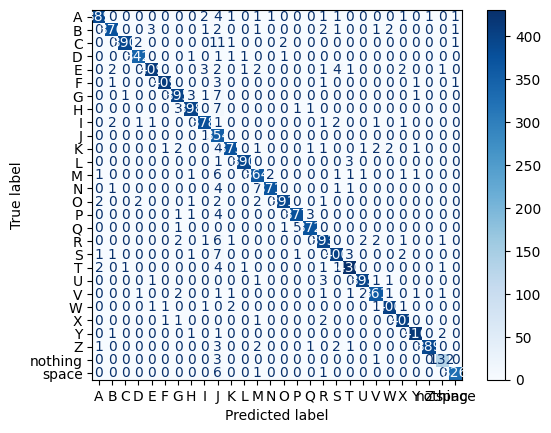

Epoch 38/50: 100%|██████████| 3210/3210 [03:46<00:00, 14.17batch/s, loss=0.0958, accuracy=97.6]  


Epoch [38/50], Loss: 0.0765, Accuracy: 97.59%
Memoria asignada durante el entrenamiento: 0.39 GB
Memoria reservada durante el entrenamiento: 0.90 GB
Validation Loss: 0.0793, Validation Accuracy: 97.48%
Classification Report:
              precision    recall  f1-score   support

           A       0.98      0.97      0.97       403
           B       0.97      0.97      0.97       390
           C       0.98      0.96      0.97       407
           D       0.99      0.98      0.98       347
           E       0.99      0.96      0.98       428
           F       0.99      0.99      0.99       416
           G       0.98      0.98      0.98       408
           H       0.99      0.97      0.98       410
           I       0.97      0.98      0.97       388
           J       0.81      0.98      0.89       355
           K       0.98      0.96      0.97       391
           L       0.99      0.99      0.99       394
           M       0.97      0.96      0.97       379
           N      

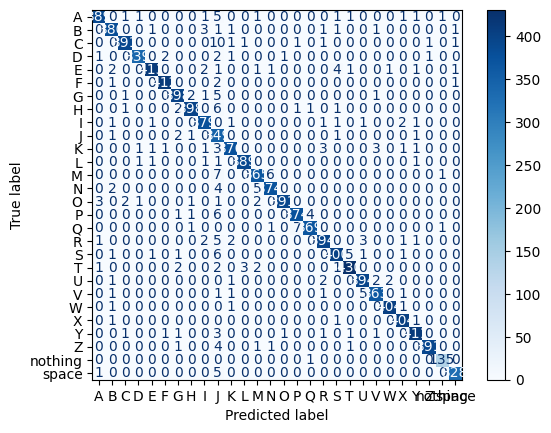

Epoch 39/50: 100%|██████████| 3210/3210 [03:45<00:00, 14.23batch/s, loss=0.0674, accuracy=97.6]  


Epoch [39/50], Loss: 0.0766, Accuracy: 97.59%
Memoria asignada durante el entrenamiento: 0.39 GB
Memoria reservada durante el entrenamiento: 0.90 GB
Validation Loss: 0.0807, Validation Accuracy: 97.42%
Classification Report:
              precision    recall  f1-score   support

           A       0.98      0.96      0.97       403
           B       0.97      0.96      0.97       390
           C       0.99      0.96      0.98       407
           D       0.98      0.98      0.98       347
           E       0.98      0.97      0.98       428
           F       1.00      0.98      0.99       416
           G       0.98      0.97      0.98       408
           H       0.98      0.97      0.98       410
           I       0.96      0.97      0.96       388
           J       0.81      0.99      0.89       355
           K       0.98      0.97      0.98       391
           L       1.00      1.00      1.00       394
           M       0.97      0.96      0.96       379
           N      

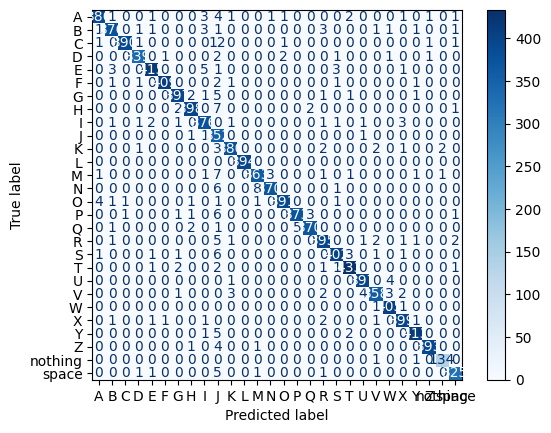

Epoch 40/50: 100%|██████████| 3210/3210 [03:46<00:00, 14.14batch/s, loss=0.0853, accuracy=97.6]  


Epoch [40/50], Loss: 0.0761, Accuracy: 97.63%
Memoria asignada durante el entrenamiento: 0.39 GB
Memoria reservada durante el entrenamiento: 0.90 GB
Validation Loss: 0.0846, Validation Accuracy: 97.39%
Classification Report:
              precision    recall  f1-score   support

           A       0.98      0.96      0.97       403
           B       0.98      0.97      0.98       390
           C       0.99      0.97      0.98       407
           D       0.99      0.98      0.99       347
           E       0.98      0.97      0.98       428
           F       1.00      0.99      0.99       416
           G       0.98      0.97      0.98       408
           H       0.98      0.98      0.98       410
           I       0.96      0.96      0.96       388
           J       0.81      1.00      0.89       355
           K       0.97      0.96      0.97       391
           L       1.00      0.99      0.99       394
           M       0.96      0.97      0.96       379
           N      

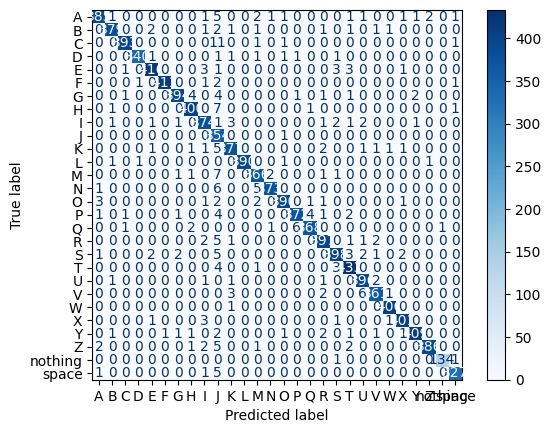

Epoch 41/50: 100%|██████████| 3210/3210 [03:47<00:00, 14.13batch/s, loss=0.0151, accuracy=97.6]  


Epoch [41/50], Loss: 0.0770, Accuracy: 97.56%
Memoria asignada durante el entrenamiento: 0.39 GB
Memoria reservada durante el entrenamiento: 0.90 GB
Validation Loss: 0.0802, Validation Accuracy: 97.47%
Classification Report:
              precision    recall  f1-score   support

           A       0.97      0.96      0.97       403
           B       0.97      0.96      0.97       390
           C       0.98      0.97      0.97       407
           D       0.99      0.98      0.99       347
           E       0.97      0.97      0.97       428
           F       1.00      0.98      0.99       416
           G       0.98      0.98      0.98       408
           H       0.99      0.98      0.98       410
           I       0.97      0.97      0.97       388
           J       0.81      0.99      0.89       355
           K       0.97      0.97      0.97       391
           L       1.00      1.00      1.00       394
           M       0.97      0.97      0.97       379
           N      

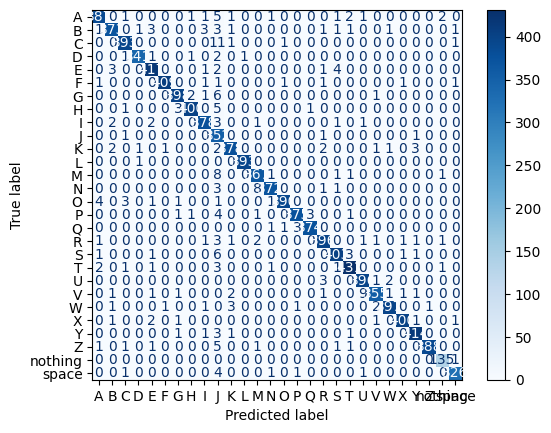

Epoch 42/50: 100%|██████████| 3210/3210 [03:47<00:00, 14.11batch/s, loss=0.0149, accuracy=97.6]  


Epoch [42/50], Loss: 0.0761, Accuracy: 97.62%
Memoria asignada durante el entrenamiento: 0.39 GB
Memoria reservada durante el entrenamiento: 0.90 GB
Validation Loss: 0.0847, Validation Accuracy: 97.36%
Classification Report:
              precision    recall  f1-score   support

           A       0.98      0.96      0.97       403
           B       0.98      0.97      0.98       390
           C       0.99      0.96      0.98       407
           D       1.00      0.99      0.99       347
           E       0.98      0.96      0.97       428
           F       0.99      0.99      0.99       416
           G       0.97      0.97      0.97       408
           H       0.98      0.97      0.98       410
           I       0.98      0.98      0.98       388
           J       0.80      0.99      0.88       355
           K       0.97      0.96      0.96       391
           L       0.99      0.99      0.99       394
           M       0.96      0.96      0.96       379
           N      

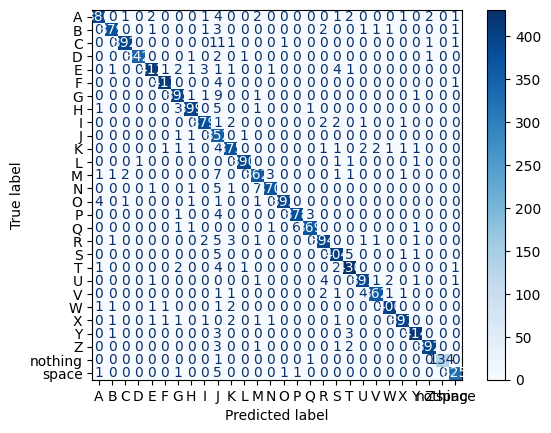

Epoch 43/50: 100%|██████████| 3210/3210 [03:46<00:00, 14.15batch/s, loss=0.155, accuracy=97.6]   


Epoch [43/50], Loss: 0.0768, Accuracy: 97.58%
Memoria asignada durante el entrenamiento: 0.39 GB
Memoria reservada durante el entrenamiento: 0.90 GB
Validation Loss: 0.0828, Validation Accuracy: 97.31%
Classification Report:
              precision    recall  f1-score   support

           A       0.99      0.96      0.97       403
           B       0.96      0.96      0.96       390
           C       0.99      0.96      0.98       407
           D       0.98      0.98      0.98       347
           E       0.98      0.96      0.97       428
           F       0.99      0.99      0.99       416
           G       0.98      0.97      0.98       408
           H       0.99      0.98      0.98       410
           I       0.99      0.97      0.98       388
           J       0.81      0.99      0.89       355
           K       0.98      0.95      0.96       391
           L       0.99      0.99      0.99       394
           M       0.97      0.96      0.96       379
           N      

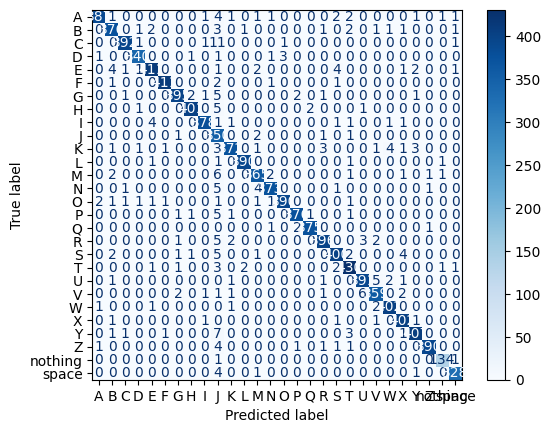

Epoch 44/50: 100%|██████████| 3210/3210 [03:48<00:00, 14.05batch/s, loss=0.0499, accuracy=97.5]  


Epoch [44/50], Loss: 0.0776, Accuracy: 97.54%
Memoria asignada durante el entrenamiento: 0.39 GB
Memoria reservada durante el entrenamiento: 0.90 GB
Validation Loss: 0.0831, Validation Accuracy: 97.48%
Classification Report:
              precision    recall  f1-score   support

           A       0.98      0.96      0.97       403
           B       0.98      0.97      0.97       390
           C       0.98      0.96      0.97       407
           D       0.99      0.99      0.99       347
           E       0.99      0.98      0.98       428
           F       0.99      0.99      0.99       416
           G       0.98      0.97      0.97       408
           H       0.98      0.97      0.98       410
           I       0.97      0.96      0.96       388
           J       0.82      0.98      0.90       355
           K       0.96      0.95      0.96       391
           L       1.00      1.00      1.00       394
           M       0.97      0.96      0.97       379
           N      

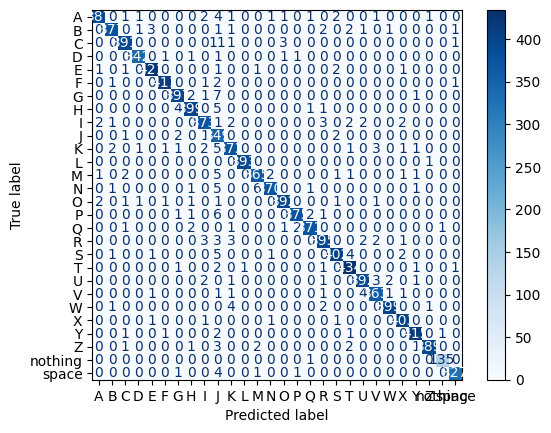

Epoch 45/50: 100%|██████████| 3210/3210 [03:48<00:00, 14.06batch/s, loss=0.126, accuracy=97.6]   


Epoch [45/50], Loss: 0.0759, Accuracy: 97.62%
Memoria asignada durante el entrenamiento: 0.39 GB
Memoria reservada durante el entrenamiento: 0.90 GB
Validation Loss: 0.0756, Validation Accuracy: 97.60%
Classification Report:
              precision    recall  f1-score   support

           A       0.98      0.97      0.97       403
           B       0.97      0.97      0.97       390
           C       0.99      0.96      0.98       407
           D       0.99      0.99      0.99       347
           E       0.98      0.96      0.97       428
           F       1.00      0.99      0.99       416
           G       0.98      0.97      0.97       408
           H       0.99      0.97      0.98       410
           I       0.98      0.96      0.97       388
           J       0.81      0.99      0.89       355
           K       0.97      0.97      0.97       391
           L       0.99      0.99      0.99       394
           M       0.97      0.97      0.97       379
           N      

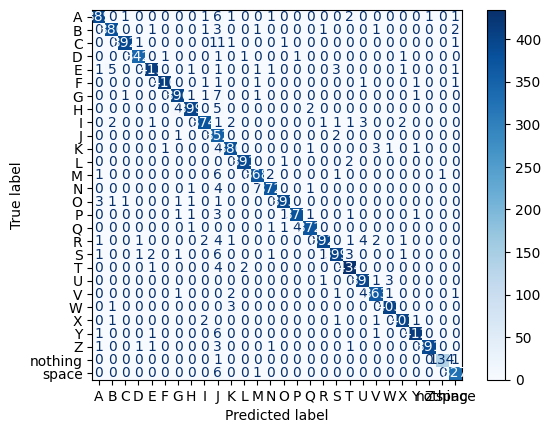

Epoch 46/50: 100%|██████████| 3210/3210 [05:20<00:00, 10.01batch/s, loss=0.00564, accuracy=97.6] 


Epoch [46/50], Loss: 0.0766, Accuracy: 97.58%
Memoria asignada durante el entrenamiento: 0.39 GB
Memoria reservada durante el entrenamiento: 0.90 GB
Validation Loss: 0.0750, Validation Accuracy: 97.66%
Classification Report:
              precision    recall  f1-score   support

           A       0.99      0.96      0.97       403
           B       0.98      0.96      0.97       390
           C       0.99      0.97      0.98       407
           D       0.99      0.99      0.99       347
           E       0.98      0.98      0.98       428
           F       1.00      0.99      0.99       416
           G       0.99      0.98      0.99       408
           H       0.99      0.98      0.99       410
           I       0.96      0.97      0.97       388
           J       0.82      1.00      0.90       355
           K       0.97      0.96      0.97       391
           L       0.99      1.00      1.00       394
           M       0.97      0.96      0.97       379
           N      

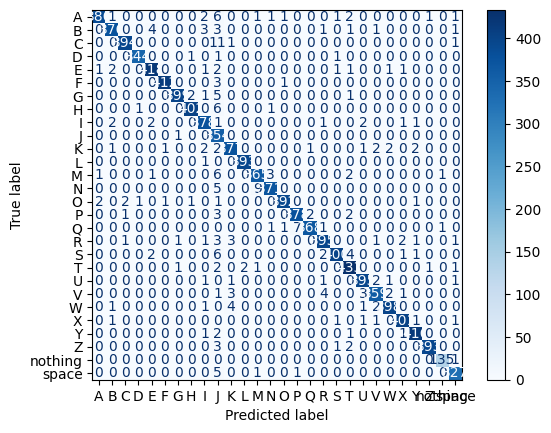

Epoch 47/50: 100%|██████████| 3210/3210 [03:54<00:00, 13.70batch/s, loss=0.118, accuracy=97.6]   


Epoch [47/50], Loss: 0.0764, Accuracy: 97.58%
Memoria asignada durante el entrenamiento: 0.39 GB
Memoria reservada durante el entrenamiento: 0.90 GB
Validation Loss: 0.0822, Validation Accuracy: 97.43%
Classification Report:
              precision    recall  f1-score   support

           A       0.97      0.96      0.97       403
           B       0.98      0.96      0.97       390
           C       0.99      0.96      0.97       407
           D       0.99      0.98      0.99       347
           E       0.98      0.97      0.98       428
           F       0.99      0.99      0.99       416
           G       0.99      0.96      0.98       408
           H       0.98      0.97      0.97       410
           I       0.97      0.98      0.98       388
           J       0.80      0.99      0.89       355
           K       0.98      0.96      0.97       391
           L       0.99      0.99      0.99       394
           M       0.96      0.96      0.96       379
           N      

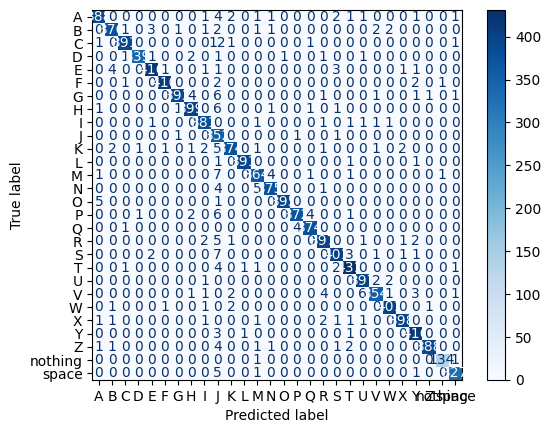

Epoch 48/50: 100%|██████████| 3210/3210 [03:54<00:00, 13.71batch/s, loss=0.012, accuracy=97.5]   


Epoch [48/50], Loss: 0.0774, Accuracy: 97.55%
Memoria asignada durante el entrenamiento: 0.39 GB
Memoria reservada durante el entrenamiento: 0.90 GB
Validation Loss: 0.0751, Validation Accuracy: 97.64%
Classification Report:
              precision    recall  f1-score   support

           A       0.99      0.96      0.98       403
           B       0.97      0.96      0.97       390
           C       0.99      0.97      0.98       407
           D       0.99      0.98      0.99       347
           E       0.99      0.97      0.98       428
           F       0.99      0.98      0.99       416
           G       0.99      0.96      0.98       408
           H       0.99      0.98      0.98       410
           I       0.98      0.97      0.98       388
           J       0.81      1.00      0.90       355
           K       0.98      0.96      0.97       391
           L       1.00      0.99      0.99       394
           M       0.96      0.96      0.96       379
           N      

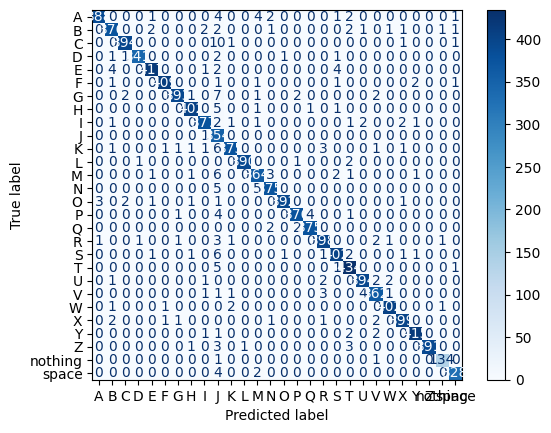

Epoch 49/50: 100%|██████████| 3210/3210 [03:51<00:00, 13.90batch/s, loss=0.0812, accuracy=97.6]  


Epoch [49/50], Loss: 0.0776, Accuracy: 97.57%
Memoria asignada durante el entrenamiento: 0.39 GB
Memoria reservada durante el entrenamiento: 0.90 GB
Validation Loss: 0.0813, Validation Accuracy: 97.38%
Classification Report:
              precision    recall  f1-score   support

           A       0.98      0.97      0.98       403
           B       0.98      0.96      0.97       390
           C       0.99      0.96      0.98       407
           D       0.99      0.97      0.98       347
           E       0.98      0.96      0.97       428
           F       0.99      0.98      0.99       416
           G       0.99      0.96      0.98       408
           H       0.98      0.97      0.98       410
           I       0.98      0.97      0.98       388
           J       0.81      1.00      0.89       355
           K       0.97      0.96      0.97       391
           L       0.99      0.99      0.99       394
           M       0.96      0.97      0.96       379
           N      

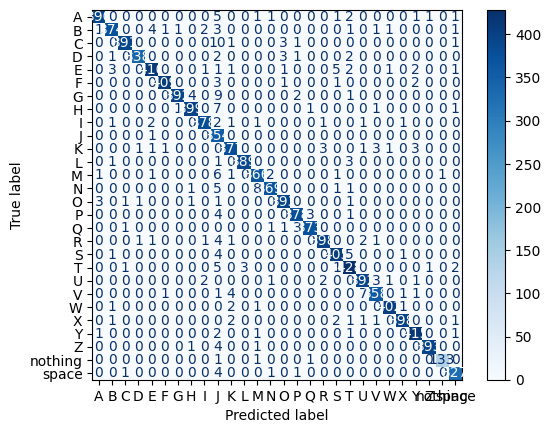

Epoch 50/50: 100%|██████████| 3210/3210 [03:52<00:00, 13.79batch/s, loss=0.135, accuracy=97.6]   


Epoch [50/50], Loss: 0.0768, Accuracy: 97.60%
Memoria asignada durante el entrenamiento: 0.39 GB
Memoria reservada durante el entrenamiento: 0.90 GB
Validation Loss: 0.0762, Validation Accuracy: 97.67%
Classification Report:
              precision    recall  f1-score   support

           A       0.99      0.96      0.98       403
           B       0.98      0.97      0.97       390
           C       0.99      0.96      0.98       407
           D       0.99      0.99      0.99       347
           E       0.98      0.98      0.98       428
           F       0.99      0.99      0.99       416
           G       0.98      0.97      0.98       408
           H       0.97      0.98      0.98       410
           I       0.98      0.97      0.98       388
           J       0.82      1.00      0.90       355
           K       0.98      0.96      0.97       391
           L       0.99      0.99      0.99       394
           M       0.97      0.97      0.97       379
           N      

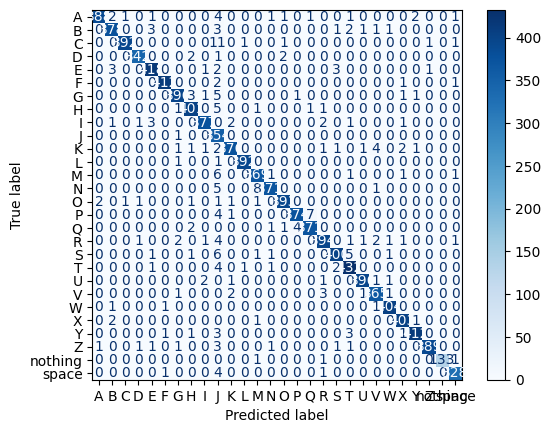

Validation Loss: 0.0815, Validation Accuracy: 97.44%
Classification Report:
              precision    recall  f1-score   support

           A       0.98      0.97      0.97       403
           B       0.96      0.96      0.96       390
           C       0.99      0.97      0.98       407
           D       0.99      0.99      0.99       347
           E       0.98      0.98      0.98       428
           F       1.00      0.99      0.99       416
           G       0.99      0.97      0.98       408
           H       0.97      0.97      0.97       410
           I       0.97      0.97      0.97       388
           J       0.81      1.00      0.90       355
           K       0.97      0.97      0.97       391
           L       0.99      0.99      0.99       394
           M       0.96      0.95      0.95       379
           N       0.99      0.97      0.98       385
           O       1.00      0.98      0.99       401
           P       0.98      0.97      0.98       386
     

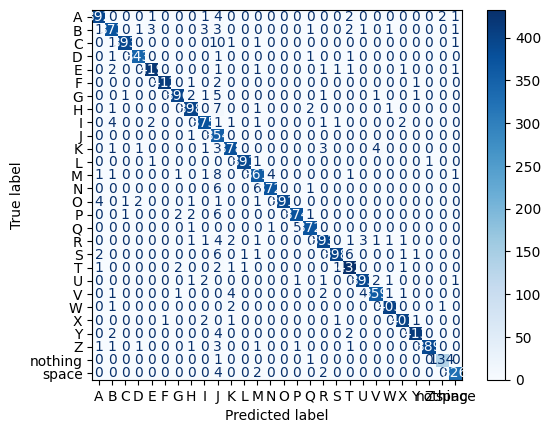

In [19]:
class SignLanguageModel(nn.Module):
    def __init__(self):
        super(SignLanguageModel, self).__init__()
        self.base_model = resnet18(pretrained=True)
        self.base_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, 29)
    
    def forward(self, x):
        return self.base_model(x)

model = SignLanguageModel().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

def validate_model(model, test_loader, criterion):
    model.eval()
    all_labels = []
    all_preds = []
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    epoch_loss = running_loss / len(test_loader)
    epoch_acc = 100 * correct / total
    print(f"Validation Loss: {epoch_loss:.4f}, Validation Accuracy: {epoch_acc:.2f}%")
    
    # Reporte de clasificación
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=dataset.classes))

    # Matriz de confusión
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=50):
    model.train()
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch") as pbar:
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                optimizer.zero_grad()
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                pbar.set_postfix({"loss": loss.item(), "accuracy": 100 * correct / total})
                pbar.update(1)
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")
        
        scheduler.step()
        if torch.cuda.is_available():
            print(f"Memoria asignada durante el entrenamiento: {torch.cuda.memory_allocated(0) / 1e9:.2f} GB")
            print(f"Memoria reservada durante el entrenamiento: {torch.cuda.memory_reserved(0) / 1e9:.2f} GB")
            torch.cuda.empty_cache()

        # Evaluación en el conjunto de validación
        validate_model(model, test_loader, criterion)

# Entrenar el modelo
train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=50)

# Evaluar el modelo
validate_model(model, test_loader, criterion)


In [20]:
# Guardar el modelo entrenado
torch.save(model.state_dict(), 'modelo_final.pth')
print("Modelo guardado como 'smodelo_final.pth'")

Modelo guardado como 'smodelo_final.pth'


: 

In [ ]:
import os
import cv2
import mediapipe as mp
import numpy as np
from tqdm import tqdm
from multiprocessing import Pool, cpu_count

mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

def detect_and_annotate_hand(image_path, output_dir, margin=40):  # Añadir margen adicional
    image = cv2.imread(image_path)
    with mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5) as hands:
        results = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                h, w, c = image.shape
                x_min = min([landmark.x for landmark in hand_landmarks.landmark]) * w
                x_max = max([landmark.x for landmark in hand_landmarks.landmark]) * w
                y_min = min([landmark.y for landmark in hand_landmarks.landmark]) * h
                y_max = max([landmark.y for landmark in hand_landmarks.landmark]) * h
                
                # Añadir margen
                x_min = max(0, int(x_min - margin))
                x_max = min(w, int(x_max + margin))
                y_min = max(0, int(y_min - margin))
                y_max = min(h, int(y_max + margin))
                
                # Recortar la imagen
                cropped_image = image[y_min:y_max, x_min:x_max]
                
                # Dibujar puntos clave y conexiones en la imagen recortada
                for landmark in hand_landmarks.landmark:
                    landmark_px = (int(landmark.x * (x_max - x_min)), int(landmark.y * (y_max - y_min)))
                    cv2.circle(cropped_image, landmark_px, 2, (0, 255, 0), -1)
                mp_drawing.draw_landmarks(cropped_image, hand_landmarks, mp_hands.HAND_CONNECTIONS)
                
                # Guardar la imagen anotada
                class_name = os.path.basename(os.path.dirname(image_path))
                new_filename = os.path.join(output_dir, class_name, os.path.basename(image_path))
                if not os.path.exists(os.path.dirname(new_filename)):
                    os.makedirs(os.path.dirname(new_filename))
                cv2.imwrite(new_filename, cropped_image)
                return

def preprocess_and_save_images(input_dir, output_dir):
    image_paths = []
    for root, _, files in os.walk(input_dir):
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(root, file))
    
    # Usar todos los procesadores disponibles
    with Pool(cpu_count()) as pool:
        args = [(img_path, output_dir) for img_path in image_paths]
        list(tqdm(pool.starmap(detect_and_annotate_hand, args), total=len(image_paths)))

# Preprocesar y guardar imágenes
preprocess_and_save_images('datasets/ASL_Alphabet_Dataset/asl_alphabet_train', 'datasets/ASL_Alphabet_Dataset/processed_train_2')
